# Data exploration, 2D and 3D plotting

*Script for the data exploration to understand the data.*

**Aims of the script:**
* Load a device-specific dataframe (eg: one csv file containing the data acquired by one device)
* Identify a part of the device-specific dataframe that you want to study: either a specific day or night (part 2) or several days (part 3)
* Normalize the data using standardscaler
* Plot the time series in 2D
* Plot multidimensional data in 3D independently from time. Use K-means to identify multidimensional clusters

**To run the script:**
- To speed up the processing, this script was designed to work with a device-specific dataframe that should be located in the folder ../data/interim. The user enters the number of the device in a two-digit string format ('01', '02'... '51') and follows the instructions.
- If the device-specific dataframes do not exist yet, it will be automatically generated. This script expects to find the following files in the folder ../Data/raw:'
        * raw_data_part1.csv
        * raw_data_part2.csv
        * raw_data_part3.csv
        * raw_data_part4.csv
        * raw_data_part5.csv

**Interpretation and conclusions:**
* This code was written to be flexible to change device number and time frame.
* Depending on the device, the data is variable among devices and between devices. There are trends going over several or highly instable signal difficult to analyse.

> Questions:
> Contact Guillaume Azarias at guillaume.azarias@hotmail.com

## 1 - Loading the relevant library

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from pytz import timezone
import re
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style="whitegrid")

# To play with the interactive plots, uncomment the following lines
# %matplotlib notebook

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
from functions import load_ds, load_raw_data, df_dev_generator, df_dev_formater, df_generator, day_night_csv

## 2 - Plotting the data of a specific night or day

    a. Load a specific dataset by inserting the number of the device as a string of 2 digits. Use the interactive plot to identify the date and time when the resident wakes up or goes to bed 
    b. Fill the information collected in the step a into the dataframe day_night_data. Run day_night_csv that will create csv files in the folder ../Data/interim
    c. Load a specific day or night dataframe which has the following name structure:
    name = str(device) + '_' + str(day_night) + '_' + str(days) + '_from_' + str(hour_formatted)
    d. Data normalisation
    e. 2D plotting of the time course 
    f. 3D plotting: representing the data of the different parameters (light, CO2, humidity and temperature) and look for clusters using K-mean clustering.

### 2a - Load the device-specific dataset

Check report:
##############################################
['Device contained in the dataset: device01']
['Tenant using the device: tenant01']

Data types:
device                                object
tenant                                object
ds             datetime64[ns, Europe/Zurich]
light                                float64
temperature                          float64
humidity                             float64
co2                                  float64
dtype: object

Available data from the 2019-05-01 to the 2020-03-26.

Showing the dataframe. Use it to find the time window you would like to investigate:
Full dataset: 2019-05-01 to the 2020-03-26. Analysed data the 2019-05-01 to the 2020-03-26.


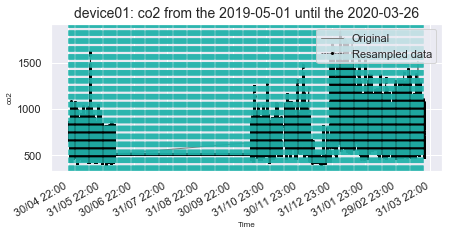

In [3]:
# Enter the number of the device as a string with two digits and execute the cell
device_nb = '01'

# Load the device-specific dataframe. Show the most important information
assert isinstance(device_nb, str) and len(device_nb)==2 and sum(d.isdigit() for d in device_nb)==2, 'WARNING: device_nb must be a string of 2-digits!'
assert int(device_nb)>=1 and int(device_nb)<=51, 'This device does not belong to the dataframe'
device, df_dev = load_ds(device_nb)

# Convert the variable device from a np.array to a string
regex = re.compile('[^A-Za-z0-9]')
device = regex.sub('', str(device))

# Show the full device-specific dataframe
print('\nShowing the dataframe. Use it to find the time window you would like to investigate:')
start = df_dev['ds'][0].strftime('%Y-%m-%d')
last = df_dev['ds'][df_dev.shape[0]-1].strftime('%Y-%m-%d')
df, predict_n, today_index, lookback_n = df_generator(df_dev, device, 'co2', start, last,  '1T', 0.016)
plt.show()

**NOTE: *This figure is meant to be used in the interactive mode of jupyter notebook. It will be displayed small and with green horizontal lines on the Gitlab. To use the interactive mode, uncomment the line # %matplotlib notebook and run the notebook.***

### 2b - Generating day and night-specific dataframes

This function generates dataframes for all parameters from the time they go to bed to the time they wake up.
This function was for exploration but not further use in the analysis.
    
Parameters:
- device: String indicating the device.
- day_night_dataframe: Pandas dataframe containing the columns
          day_gotobed(%Y-%m-%d), time_gotobed(%H:%M),
          day_wakeup(%Y-%m-%d), time_wakeup(%H:%M)
          
Return:
- save one csv for of the data of night
- save one csv for of the data of day

In [4]:
# Example Device01, from 2019 05 02 to the 2019 05 12
# Indicate here the date and time when the resident goes to bed and wake up

day_night_data = [['2019-05-01', '20:00', '2019-05-02', '7:00'],
 ['2019-05-02', '20:00', '2019-05-03', '6:30'],
 ['2019-05-03', '20:30', '2019-05-04', '9:00'],
 ['2019-05-04', '19:00', '2019-05-05', '6:00'],
 ['2019-05-05', '19:00', '2019-05-06', '8:30'],
 ['2019-05-06', '19:00', '2019-05-07', '6:00'],
 ['2019-05-07', '20:00', '2019-05-08', '8:30'],
 ['2019-05-08', '18:00', '2019-05-09', '7:00'],
 ['2019-05-09', '18:00', '2019-05-10', '6:30'],
 ['2019-05-10', '18:00', '2019-05-11', '6:30'],
 ['2019-05-11', '18:00', '2019-05-12', '6:00'],
 ['2019-05-12', '18:00', '2019-05-13', '5:00']]

day_night_df = pd.DataFrame(day_night_data, columns = ['day_gotobed', 'time_gotobed',
                                                        'day_wakeup', 'time_wakeup'])
day_night_df.head(12)

,day_gotobed,time_gotobed,day_wakeup,time_wakeup
0,2019-05-01,20:00,2019-05-02,7:00
1,2019-05-02,20:00,2019-05-03,6:30
2,2019-05-03,20:30,2019-05-04,9:00
3,2019-05-04,19:00,2019-05-05,6:00
4,2019-05-05,19:00,2019-05-06,8:30
5,2019-05-06,19:00,2019-05-07,6:00
6,2019-05-07,20:00,2019-05-08,8:30
7,2019-05-08,18:00,2019-05-09,7:00
8,2019-05-09,18:00,2019-05-10,6:30
9,2019-05-10,18:00,2019-05-11,6:30


In [5]:
day_night_csv(df_dev, device, day_night_df)

csv generation completed in 2 seconds.


### 2c - Load a specific day or night dataframe: Example of the day of the 2019-05-03 that started at 6:30AM

In [6]:
day_night = 'Day' # String. Day or Night
days = '2019-05-03' # String.
hour_formatted = '6h30' 

In [7]:
folder = '../data/interim/'

name = str(device) + '_' + str(day_night) + '_' + str(days) + '_from_' + str(hour_formatted)

file_name = folder + name + '.csv'
file_name

df = pd.read_csv(file_name)
df = df.drop(columns=['Unnamed: 0'])

In [8]:
df.head(-10)

,device,tenant,ds,light,temperature,humidity,co2
0,device01,tenant01,2019-05-03 06:30:13.777000+02:00,0.0,22.918649,28.651867,758.471741
1,device01,tenant01,2019-05-03 06:30:33.833000+02:00,0.0,22.902628,28.638134,759.643616
2,device01,tenant01,2019-05-03 06:30:53.884000+02:00,0.0,22.902628,28.638134,759.312256
3,device01,tenant01,2019-05-03 06:31:13.930000+02:00,0.0,22.945352,28.612190,758.909363
4,device01,tenant01,2019-05-03 06:31:33.978000+02:00,0.0,22.902628,28.607613,757.948181
...,...,...,...,...,...,...,...
2498,device01,tenant01,2019-05-03 20:25:03.401000+02:00,3.0,23.174997,25.247578,873.006653
2499,device01,tenant01,2019-05-03 20:25:23.451000+02:00,3.0,23.158975,25.233845,873.681824
2500,device01,tenant01,2019-05-03 20:25:43.499000+02:00,3.0,23.201700,25.209431,873.042236
2501,device01,tenant01,2019-05-03 20:26:03.568000+02:00,3.0,23.174997,25.177387,873.040100


### 2d - Data normalization

In [9]:
data = df.iloc[:, 3:]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
scaled_data.head(2)

,light,temperature,humidity,co2
0,-1.036159,0.597524,1.469806,0.304394
1,-1.036159,0.574153,1.462935,0.312521


In [10]:
df_scaled = df.drop(columns=['light', 'temperature', 'humidity', 'co2'])
df_scaled = pd.concat([df_scaled, scaled_data], axis=1)
df_scaled.loc[:, 'ds'] = pd.to_datetime(df_scaled.loc[:, 'ds'])
# df_scaled.dtypes
df_scaled = df_scaled.set_index('ds')
df_scaled.head(2)

,device,tenant,light,temperature,humidity,co2
ds,,,,,,
2019-05-03 06:30:13.777000+02:00,device01,tenant01,-1.036159,0.597524,1.469806,0.304394
2019-05-03 06:30:33.833000+02:00,device01,tenant01,-1.036159,0.574153,1.462935,0.312521


### 2e. 2D plotting: distribution and time course

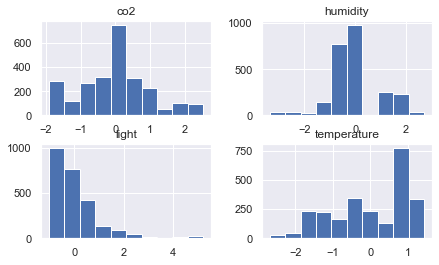

In [11]:
scaled_data.hist(figsize=(7,4), linewidth=1)
plt.show()

In [12]:
# Correlation matrix
df_scaled.corr()

,light,temperature,humidity,co2
light,1.000000,-0.378529,-0.366678,-0.255242
temperature,-0.378529,1.000000,0.347017,0.739063
humidity,-0.366678,0.347017,1.000000,0.407933
co2,-0.255242,0.739063,0.407933,1.000000


There is one correlation between the parameters:
- **co2 is correlated with the temperature**

*Note: This is variable among devices.*

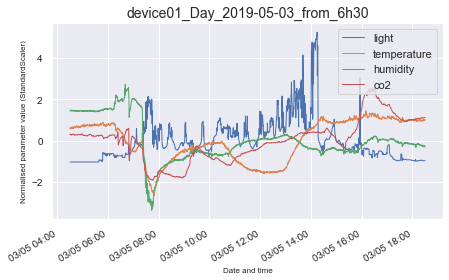

In [13]:
plt.close()
ax = df_scaled.plot(figsize=(7,4), linewidth=1, fontsize=10)
myFmt = DateFormatter("%d/%m %H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.xlabel('Date and time', fontsize=8)
plt.ylabel('Normalised parameter value (StandardScaler)', fontsize=8)
plt.title(name, fontsize=14)
plt.legend(loc='upper right')
plt.show()

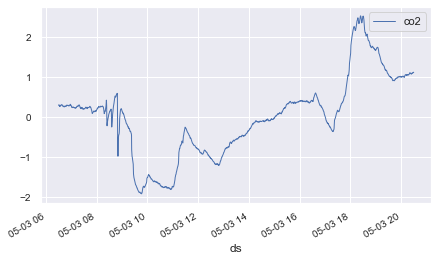

In [14]:
# Plotting of raw data

CO2 = df_scaled[['co2']]
CO2.plot(figsize=(7,4), linewidth=1, fontsize=10)
ax.xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.show()

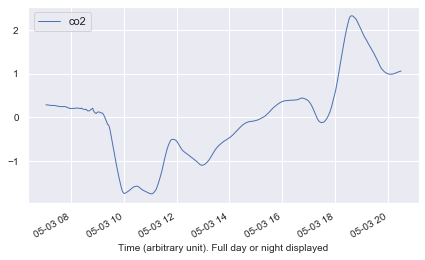

In [15]:
# Identifying trend in Time Series

CO2.rolling(100).mean().plot(figsize=(7,4), linewidth=1, fontsize=10)
plt.xlabel('Time (arbitrary unit). Full day or night displayed', fontsize=10)
plt.gcf().autofmt_xdate()
plt.show()

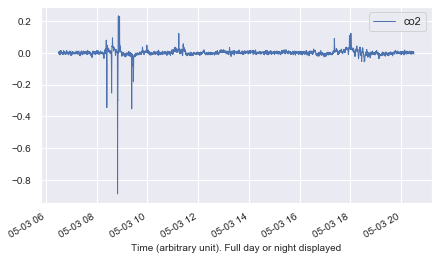

In [16]:
# First-order differencing
# import matplotlib.dates as mdates
plt.close()
from matplotlib.dates import DateFormatter
CO2.diff().plot(figsize=(7,4), linewidth=1, fontsize=10)
plt.xlabel('Time (arbitrary unit). Full day or night displayed', fontsize=10)
plt.gcf().autofmt_xdate()
# First-order differencingplt.show()

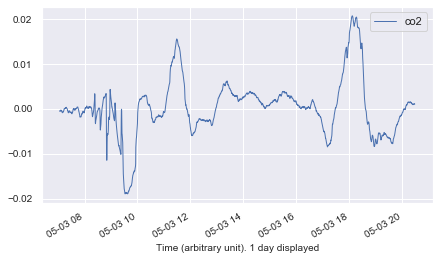

In [17]:
# First-order differencing. Smoothed data
CO2.rolling(100).mean().diff().plot(figsize=(7,4), linewidth=1, fontsize=10)
plt.xlabel('Time (arbitrary unit). 1 day displayed', fontsize=10)
plt.gcf().autofmt_xdate()
plt.show()

**Conclusion and limitation**

* Using the smoothed data of the derivative might be helpful. It may give the possibility to identify transients changes in CO2 that can be translated into the resident activity (coming and leaving the room).
* However, it would be more accurate to have more data than a specific day or night to calculate the normal resident activity. Automatically detecting day and night represents a challenge that I addressed using Prophet.

### 2f. 3D plotting to see multiparameter clusters, independently from time

This code is from this [tutorial](/Users/guillaume/Documents/DS2020/guillaume-azarias/03-Machine-Learning/Day-8-Clustering/Exercice_1_GA.py) done at the Propulsion Academy.

In [18]:
# This is the original function

def plot_3D(data_3D, labels=None, **kwargs):
    fig_ = plt.figure(figsize=(7, 7))
    ax = Axes3D(fig_)
    ax.scatter(data_3D.iloc[:, 0], data_3D.iloc[:, 1], data_3D.iloc[:, 2],
               c=labels,
               s=20,
               alpha=0.15)
    
    label = list(data_3D.columns.values)
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    ax.set_zlabel(label[2])
    return ax
    
def kmeans_clusters_3D(data_, n_clusters):
    km_ = KMeans(n_clusters)
    km_.fit(data_)

    plot_3D(data_, km_.labels_.astype(float))

    return

In [19]:
# For K-means clustering, I chose to replace NaN by 0.
# Further investigation of K-means clustering may need to consider better fillna() method
if scaled_data.isnull().sum().sum()>0:
    scaled_data = scaled_data.fillna(0)
    print('NaN removed.')
else:
    print('No NaN in the dataframe.')

No NaN in the dataframe.


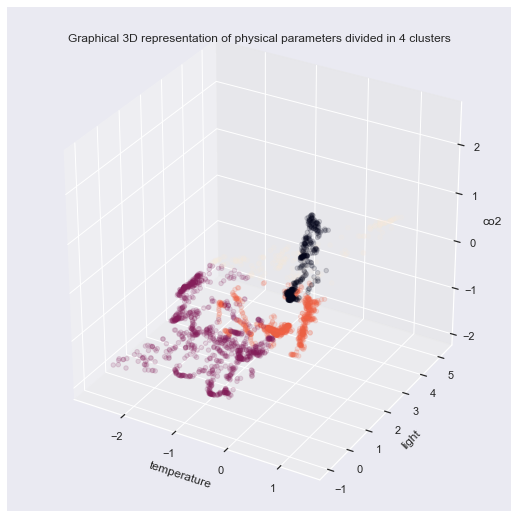

In [20]:
n_cluster = 4

kmeans_clusters_3D(scaled_data[['temperature', 'light', 'co2']], n_cluster)
plt.title('Graphical 3D representation of physical parameters divided in ' + str(n_cluster) + ' clusters')
plt.show()

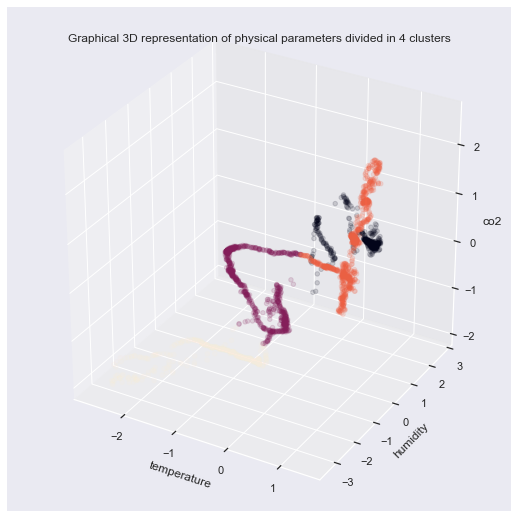

In [21]:
n_cluster = 4

kmeans_clusters_3D(scaled_data[['temperature', 'humidity', 'co2']], n_cluster)
plt.title('Graphical 3D representation of physical parameters divided in ' + str(n_cluster) + ' clusters')
plt.show()

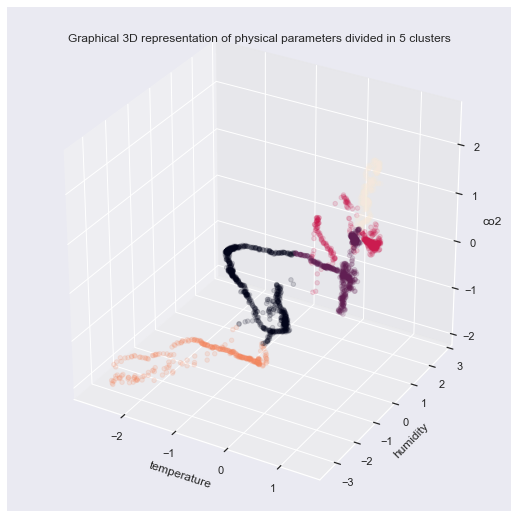

In [22]:
n_cluster = 5

kmeans_clusters_3D(scaled_data[['temperature', 'humidity', 'co2']], n_cluster)
plt.title('Graphical 3D representation of physical parameters divided in ' + str(n_cluster) + ' clusters')
plt.show()

## 3 - Plotting in 3D the dataframe of a week

    a. Load a specific dataset by inserting the number of the device as a string of 2 digits. Use the interactive plot to identify the date and time when the resident wakes up or goes to bed
    b. Decide for the start and end of the dataframe you want to plot
    c. Load and plot the data specific to the start and end of the dataframe
    d. Data normalisation
    e. 2D plotting of the time course 
    f. 3D plotting: representing the data of the different parameters (light, CO2, humidity and temperature) and look for clusters using K-mean clustering.
    
*Example: dataframe from the 2020-01-07 to the 2020-01-14*

### 3a - Load the device-specific dataset

Check report:
##############################################
['Device contained in the dataset: device01']
['Tenant using the device: tenant01']

Data types:
device                                object
tenant                                object
ds             datetime64[ns, Europe/Zurich]
light                                float64
temperature                          float64
humidity                             float64
co2                                  float64
dtype: object

Available data from the 2019-05-01 to the 2020-03-26.

Showing the dataframe. Use it to find the time window you would like to investigate:
Full dataset: 2019-05-01 to the 2020-03-26. Analysed data the 2019-05-01 to the 2020-03-26.


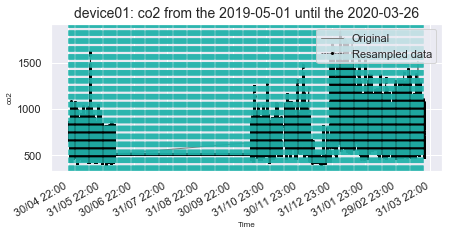

In [23]:
# Enter the number of the device as a string with two digits and execute the cell
device_nb = '01'

# Load the device-specific dataframe. Show the most important information
assert isinstance(device_nb, str) and len(device_nb)==2 and sum(d.isdigit() for d in device_nb)==2, 'WARNING: device_nb must be a string of 2-digits!'
assert int(device_nb)>=1 and int(device_nb)<=51, 'This device does not belong to the dataframe'
device, df_dev = load_ds(device_nb)

# Convert the variable device from a np.array to a string
regex = re.compile('[^A-Za-z0-9]')
device = regex.sub('', str(device))

# Show the full device-specific dataframe
print('\nShowing the dataframe. Use it to find the time window you would like to investigate:')
start = df_dev['ds'][0].strftime('%Y-%m-%d')
last = df_dev['ds'][df_dev.shape[0]-1].strftime('%Y-%m-%d')
df, predict_n, today_index, lookback_n = df_generator(df_dev, device, 'co2', start, last,  '1T', 0.016)
plt.show()

### 3b. Decide for the start and end of the dataframe you want to plot

In [24]:
start = '2020-01-07'
last = '2020-01-14'

### 3c. Load and plot the data specific to the start and end of the dataframe

In [25]:
data = pd.DataFrame(columns=['light', 'temperature', 'humidity', 'co2'])

Full dataset: 2019-05-01 to the 2020-03-26. Analysed data the 2020-01-07 to the 2020-01-14.


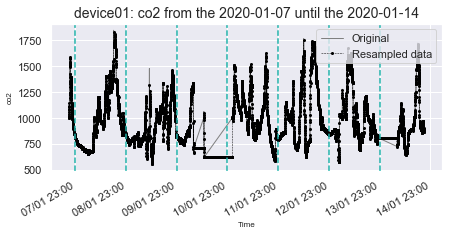

In [26]:
df, predict_n, today_index, lookback_n = df_generator(df_dev, device, 'co2', start, last,  '1T', 0.016)
plt.show()
data['co2'] = df.loc[:, 'y']

Full dataset: 2019-05-01 to the 2020-03-26. Analysed data the 2020-01-07 to the 2020-01-14.


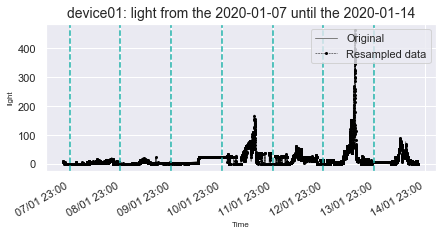

In [27]:
df, predict_n, today_index, lookback_n = df_generator(df_dev, device, 'light', start, last,  '1T', 0.016)
plt.show()
data['light'] = df.loc[:, 'y']

Full dataset: 2019-05-01 to the 2020-03-26. Analysed data the 2020-01-07 to the 2020-01-14.


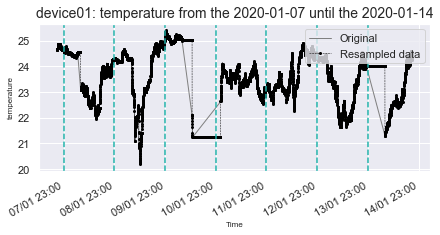

In [28]:
df, predict_n, today_index, lookback_n = df_generator(df_dev, device, 'temperature', start, last,  '1T', 0.016)
plt.show()
data['temperature'] = df.loc[:, 'y']

Full dataset: 2019-05-01 to the 2020-03-26. Analysed data the 2020-01-07 to the 2020-01-14.


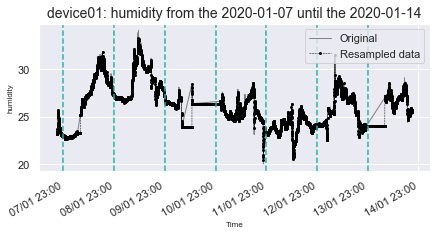

In [29]:
df, predict_n, today_index, lookback_n = df_generator(df_dev, device, 'humidity', start, last,  '1T', 0.016)
plt.show()
data['humidity'] = df.loc[:, 'y']

### 3d. Data normalisation

In [30]:
data.head()

,light,temperature,humidity,co2
ds,,,,
2020-01-07 21:01:00+01:00,9.0,24.646349,23.305105,1020.378174
2020-01-07 21:02:00+01:00,10.0,24.646349,23.227283,1019.521851
2020-01-07 21:03:00+01:00,7.0,24.659700,23.199818,1013.920532
2020-01-07 21:04:00+01:00,6.0,24.689073,23.137255,1008.149414
2020-01-07 21:05:00+01:00,6.0,24.689073,23.356985,1004.616394


In [31]:
# Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
scaled_data.head(2)

,light,temperature,humidity,co2
0,-0.182918,1.049286,-1.269571,0.336000
1,-0.143923,1.049286,-1.306102,0.332538


### 3e. 3D plotting of clusters

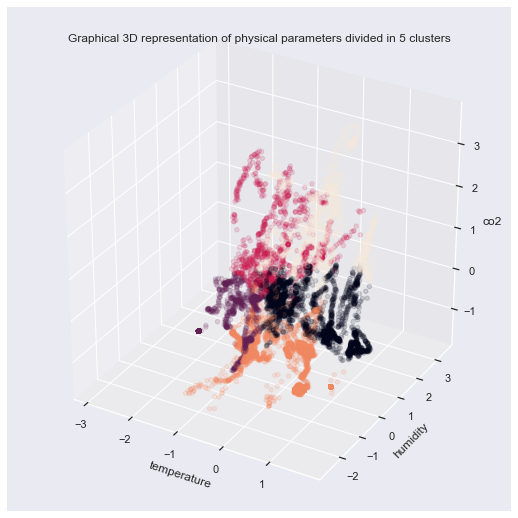

In [32]:
n_cluster = 5

kmeans_clusters_3D(scaled_data[['temperature', 'humidity', 'co2']], n_cluster)
plt.title('Graphical 3D representation of physical parameters divided in ' + str(n_cluster) + ' clusters')
plt.show()

**Conclusion and limitations**

* The K-mean clustering between parameters (light, CO$_{2}$, temperature or humidity) did not make sense to me: clustering data may work but does not provide any information on the resident activity, but rather between the physical relationships between the parameters.
* Therefore I decided to focus on the time series analysis of a single parameter with Prophet, mostly CO$_{2}$, as it is highly correlated with the resident presence.